## PART I

*   How to **download** a dataset.
*   How to **inspect** a dataset.

## PART II

* How to perform basic **text pre-processing** to identify input features.

## PART III

*   How to **train a classifier** on identified input features for sentiment classification.
*   How to **evaluate** model performance and **inspect** its predictions.

## Task

We consider the task of **document classification**.

Specifically, we consider document **sentiment analysis** on movie reviews.

## Preliminaries

First of all, we need to import some useful packages that we will use during this hands-on session.

In [35]:
# file management
import sys
import shutil
import urllib
import tarfile
from pathlib import Path

# dataframe management
import pandas as pd

# data manipulation
import numpy as np

# for readability
from typing import Iterable
from tqdm import tqdm

In [36]:
#live reveal extension
""" from notebook.services.config import ConfigManager
cm = ConfigManager()
cm.update('livereveal', {
        'width': 1024,
        'height': 768,
        'scroll': True,
}) """

" from notebook.services.config import ConfigManager\ncm = ConfigManager()\ncm.update('livereveal', {\n        'width': 1024,\n        'height': 768,\n        'scroll': True,\n}) "

# 1. Downloading the dataset

We download the IMDB movie reviews dataset.

In [37]:
class DownloadProgressBar(tqdm):
    def update_to(self, b=1, bsize=1, tsize=None):
        if tsize is not None:
            self.total = tsize
        self.update(b * bsize - self.n)

def download_url(download_path: Path, url: str):
    with DownloadProgressBar(unit='B', unit_scale=True,
                             miniters=1, desc=url.split('/')[-1]) as t:
        urllib.request.urlretrieve(url, filename=download_path, reporthook=t.update_to)

        
def download_dataset(download_path: Path, url: str):
    print("Downloading dataset...")
    download_url(url=url, download_path=download_path)
    print("Download complete!")

def extract_dataset(download_path: Path, extract_path: Path):
    print("Extracting dataset... (it may take a while...)")
    with tarfile.open(download_path) as loaded_tar:
        loaded_tar.extractall(extract_path)
    print("Extraction completed!")

In [38]:
url = "http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"
dataset_name = "aclImdb"

print(f"Current work directory: {Path.cwd()}")
dataset_folder = Path.cwd().joinpath("datasets")

if not dataset_folder.exists():
    dataset_folder.mkdir(parents=True)

dataset_tar_path = dataset_folder.joinpath("Movies.tar.gz")
dataset_path = dataset_folder.joinpath(dataset_name)

if not dataset_tar_path.exists():
    download_dataset(dataset_tar_path, url)

if not dataset_path.exists():
    extract_dataset(dataset_tar_path, dataset_folder)

Current work directory: c:\Users\ardiz\OneDrive\Desktop\Projects\AIML-Research\ML Foundations\4 - NLP\UniBo\T1-PreProcessing-TextClassification-ErrorAnalysis


Let's have a look at the files we have downloaded to understand the dataset structure.

In [39]:
# an example
file_path = dataset_folder.joinpath(dataset_name, 'train', 'pos', "0_9.txt")

if file_path.is_file():
    # open the file
    with file_path.open(mode='r', encoding='utf-8') as text_file:
        text = text_file.read()
        print(text)

Bromwell High is a cartoon comedy. It ran at the same time as some other programs about school life, such as "Teachers". My 35 years in the teaching profession lead me to believe that Bromwell High's satire is much closer to reality than is "Teachers". The scramble to survive financially, the insightful students who can see right through their pathetic teachers' pomp, the pettiness of the whole situation, all remind me of the schools I knew and their students. When I saw the episode in which a student repeatedly tried to burn down the school, I immediately recalled ......... at .......... High. A classic line: INSPECTOR: I'm here to sack one of your teachers. STUDENT: Welcome to Bromwell High. I expect that many adults of my age think that Bromwell High is far fetched. What a pity that it isn't!


## 1.1 Encode the dataset into a pandas.DataFrame

We encode the loaded dataset into a dataframe to better access to its content.

In [40]:
dataframe_rows = []

for split in ['train', 'test']:
    for sentiment in ['pos', 'neg']:
        folder = dataset_folder.joinpath(dataset_name, split, sentiment)
        for file_path in folder.glob('*.txt'):            
            with file_path.open(mode='r', encoding='utf-8') as text_file:
                text = text_file.read()
                score = file_path.stem.split("_")[1]
                score = int(score)
                file_id = file_path.stem.split("_")[0]

                num_sentiment = 1 if sentiment == 'pos' else 0

                dataframe_row = {
                    "file_id": file_id,
                    "score": score,
                    "sentiment": num_sentiment,
                    "split": split,
                    "text": text
                }

                dataframe_rows.append(dataframe_row)

In [41]:
folder = Path.cwd().joinpath("datasets", "dataframes", dataset_name)
if not folder.exists():
    folder.mkdir(parents=True)

# transform the list of rows in a proper dataframe
df = pd.DataFrame(dataframe_rows)
df = df[["file_id", 
         "score",
         "sentiment",
         "split",
         "text"]
       ]
df_path = folder.with_name(dataset_name + ".pkl")
df.to_pickle(df_path)

## 1.2 Inspecting the dataset

We first have a look at the dataframe structure.

In [42]:
print("Dataframe structure:")
print(df)
print()

print("Total rows %d" % (len(df)))
print()

Dataframe structure:
      file_id  score  sentiment  split  \
0           0      9          1  train   
1       10000      8          1  train   
2       10001     10          1  train   
3       10002      7          1  train   
4       10003      8          1  train   
...       ...    ...        ...    ...   
49995    9998      1          0   test   
49996    9999      1          0   test   
49997     999      3          0   test   
49998      99      3          0   test   
49999       9      4          0   test   

                                                    text  
0      Bromwell High is a cartoon comedy. It ran at t...  
1      Homelessness (or Houselessness as George Carli...  
2      Brilliant over-acting by Lesley Ann Warren. Be...  
3      This is easily the most underrated film inn th...  
4      This is not the typical Mel Brooks film. It wa...  
...                                                  ...  
49995  I occasionally let my kids watch this garbage ...  
49

In [43]:
print("Distribution of scores: ")
print(df['score'].value_counts())
print()

print("Distribution of sentiment: ")
print(df['sentiment'].value_counts())
print()

print("Distribution of splits: ")
print(df['split'].value_counts())
print()

Distribution of scores: 
score
1     10122
10     9731
8      5859
4      5331
3      4961
7      4803
9      4607
2      4586
Name: count, dtype: int64

Distribution of sentiment: 
sentiment
1    25000
0    25000
Name: count, dtype: int64

Distribution of splits: 
split
train    25000
test     25000
Name: count, dtype: int64



In [44]:
print("Distribution of sentiments in split: ")
print(df.groupby(['split','sentiment']).size())
print()

print("Distribution of scores in split: ")
print(df.groupby(['split','score']).size())
print()

print("Differences in score distribution in split: ")
print(df.groupby(['score','split',]).size())
print()

Distribution of sentiments in split: 
split  sentiment
test   0            12500
       1            12500
train  0            12500
       1            12500
dtype: int64

Distribution of scores in split: 
split  score
test   1        5022
       2        2302
       3        2541
       4        2635
       7        2307
       8        2850
       9        2344
       10       4999
train  1        5100
       2        2284
       3        2420
       4        2696
       7        2496
       8        3009
       9        2263
       10       4732
dtype: int64

Differences in score distribution in split: 
score  split
1      test     5022
       train    5100
2      test     2302
       train    2284
3      test     2541
       train    2420
4      test     2635
       train    2696
7      test     2307
       train    2496
8      test     2850
       train    3009
9      test     2344
       train    2263
10     test     4999
       train    4732
dtype: int64



In [45]:
print("Differences among score classes in the splits: ")
print(df.groupby(['sentiment','score','split']).size())
print()

Differences among score classes in the splits: 
sentiment  score  split
0          1      test     5022
                  train    5100
           2      test     2302
                  train    2284
           3      test     2541
                  train    2420
           4      test     2635
                  train    2696
1          7      test     2307
                  train    2496
           8      test     2850
                  train    3009
           9      test     2344
                  train    2263
           10     test     4999
                  train    4732
dtype: int64



### 1.2.1 Visualization

In [46]:
# Preliminaries
import matplotlib.pyplot as plt

We first visualize sentiment class distribution.

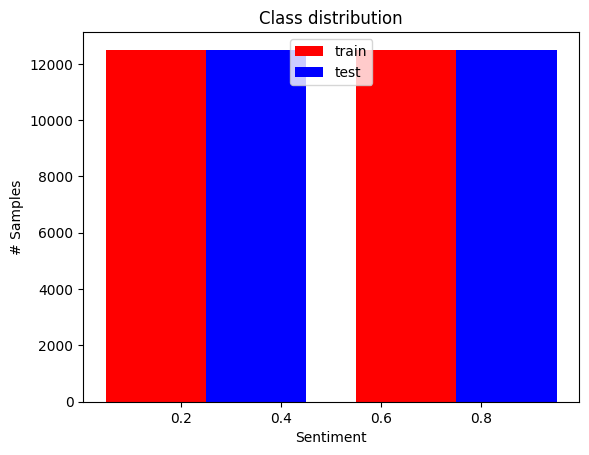

In [47]:
train_labels = df[df.split == 'train'].sentiment.values
test_labels = df[df.split == 'test'].sentiment.values

plt.hist([train_labels,test_labels], bins=2, label=['train','test'], color=["red", "blue"], align="mid")
plt.legend(loc='upper center')
plt.title('Class distribution')
plt.xlabel('Sentiment')
plt.ylabel('# Samples')
plt.show()

Then we visualize sentiment scores.

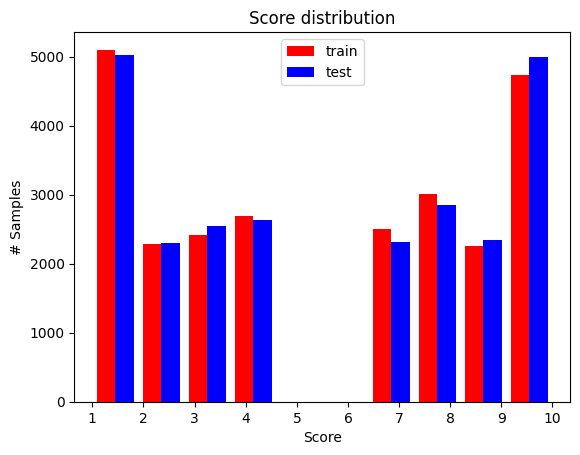

In [48]:
train_scores = df[df.split == 'train'].score.values
test_scores = df[df.split == 'test'].score.values

plt.xticks(range(1,11))
plt.hist([train_scores,test_scores], bins=10, label=['train','test'], color=["red", "blue"], align="mid")
plt.legend(loc='upper center')
plt.title('Score distribution')
plt.xlabel('Score')
plt.ylabel('# Samples')

plt.show()

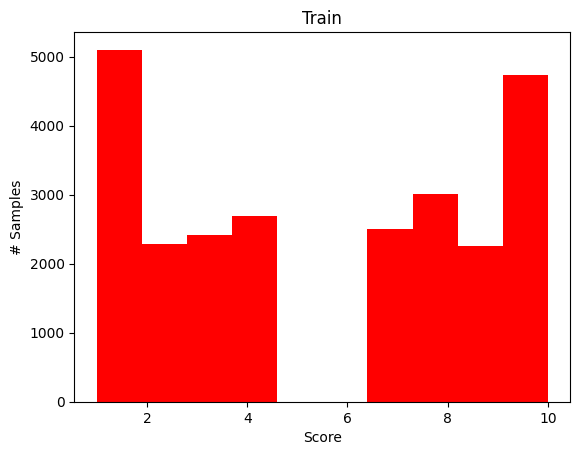

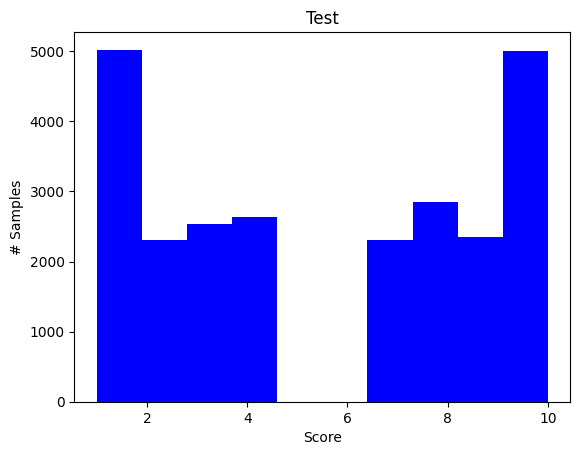

In [49]:
plot1 = plt.figure(1)
plt.hist(train_scores, 10, color="red")
plt.xlabel('Score')
plt.ylabel('# Samples')
plt.title("Train")

plot2 = plt.figure(2)
plt.hist(test_scores, 10, color="blue")
plt.xlabel('Score')
plt.ylabel('# Samples')
plt.title("Test")

plt.show()

Lastly, we check text length distribution.

In [50]:
import nltk
from nltk.tokenize import word_tokenize

# necessary for being able to tokenize
nltk.download('punkt')

train_texts = df[df.split == 'train'].text.values
test_texts = df[df.split == 'test'].text.values

train_lengths = [len(word_tokenize(text)) for text in tqdm(train_texts)]
test_lengths = [len(word_tokenize(text)) for text in tqdm(test_texts)]

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ardiz\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


100%|██████████| 25000/25000 [00:38<00:00, 649.60it/s]


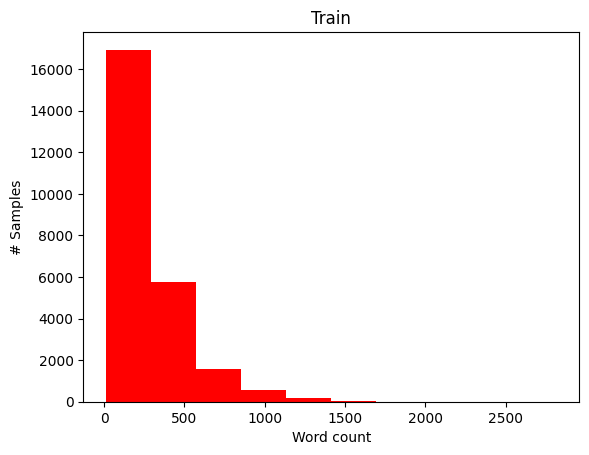

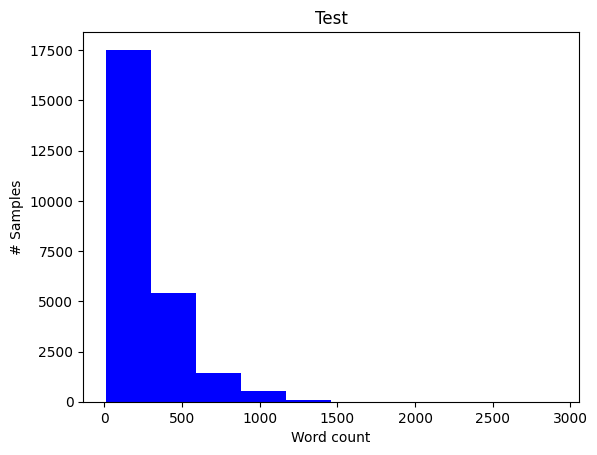

In [51]:
plot1 = plt.figure(1)
plt.hist(train_lengths, color="red")
plt.xlabel('Word count')
plt.ylabel('# Samples')
plt.title("Train")

plot2 = plt.figure(2)
plt.hist(test_lengths, 10, color="blue")
plt.xlabel('Word count')
plt.ylabel('# Samples')
plt.title("Test")

plt.show()

## 2. Feature Extraction

We are now ready to address the sentiment analysis task.

We consider the sentiment classification task for description purposes.

We first **determine** the inputs and outputs of our classifier.

Then, we define **how to encode** the inputs and outputs for the classifier.

### Inputs and Outputs

<center>
    <img src="images/inputs_outputs.png" alt="inputs and outputs" />
</center>

### Input features and Outputs

We will encode input text into a numerical format: **bag-of-words**.

<center>
    <img src="images/inputs_outputs_features.png" alt="features and outputs" />
</center>

Sentiment score prediction has the same schema where the *output label* is replaced by the sentiment score.

### 2.1 Bag-of-Words Encoding

The [scikit-learn](https://scikit-learn.org/stable/) library offers *TfidfVectorizer*, a class that performs both tokenization and the creation of the Bag-of-Words (BoW) representation of a corpus.

In particular, it computes tf-idf representation for each word token.

The class has plenty of options: it can be used also to count n-grams, excluding stop-words, and cutting off most and/or less frequent terms.

In [52]:
from sklearn.feature_extraction.text import  TfidfVectorizer

# select only the training sentences
df_train = df.loc[df['split'] == "train"]

train_texts = df_train.text.values

print("Processing corpus\n")
vectorizer =  TfidfVectorizer()

# tokenization and creation of Bag of Words representation
X_train = vectorizer.fit_transform(train_texts)

print("Shape of the matrix: (data points, features)")
print(X_train.shape)
print()

# targets for the training set
Y_train = df_train.sentiment.values 

Processing corpus

Shape of the matrix: (data points, features)
(25000, 74849)



The vectorizer **fits** on the provided texts to create an internal vocabulary.

The vocabulary is used to create the BoW representation.

The vocabulary is a dictionary that associates to each word a corresponding column in the feature matrix.

#### Check Vocabulary

Do not try to print the whole vocabulary: it is quite large ;)

Still, **it is very important** to have a look at detected tokens!

Let's check the size of the built vocabulary.

In [53]:
print("Size of vocabulary:")
print(len(vectorizer.vocabulary_))
print(type(vectorizer.vocabulary_))

Size of vocabulary:
74849
<class 'dict'>


Since the vocabulary is quite big, the BoW representation of input texts is a *sparse* matrix (see [scipy.sparse](https://docs.scipy.org/doc/scipy/reference/sparse.html) for more info).

Simply put, a sparse matrix is represented as a dictionary of non-zero entries, where the keys are the matrix coordinates.

In [54]:
print(X_train)

  (0, 34644)	0.047394461266444525
  (0, 50155)	0.08287028364871561
  (0, 72703)	0.027918294921852303
  (0, 24328)	0.09485779784272477
  (0, 23785)	0.04764802174958937
  (0, 66526)	0.03666458494606156
  (0, 2155)	0.06166887776124007
  (0, 1919)	0.07732854366244009
  (0, 40829)	0.03770129734051713
  (0, 23124)	0.0603023374239695
  (0, 72544)	0.08414563947065769
  (0, 74349)	0.040182759614367104
  (0, 46932)	0.02277311550313214
  (0, 57021)	0.10696882423195393
  (0, 30670)	0.03986001273006236
  (0, 33861)	0.09306596282618841
  (0, 38871)	0.0542382151436312
  (0, 12676)	0.05485981085044486
  (0, 53963)	0.11883065609615275
  (0, 32729)	0.0733604551139556
  (0, 19854)	0.044811917101658036
  (0, 9765)	0.09135539837480973
  (0, 68145)	0.06634799299330539
  (0, 54950)	0.09230806850172538
  (0, 63767)	0.15413528842651872
  :	:
  (24999, 32517)	0.08554199856842014
  (24999, 49147)	0.05530496122707191
  (24999, 3167)	0.03971086119358096
  (24999, 29999)	0.0441796905553389
  (24999, 47142)	0.087107

It is possible to get the dense representation of a feature matrix.

**Keep in mind** that the matrix will occupy a lot of memory.

In [55]:
print(X_train.toarray())

[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.08332142 0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]


Try taking a subset of the matrix and inspect its dense representation.

We use our fitted Vectorizer to transform test texts as well.

**Make sure** you invoke ``vectorizer.transform()`` and **not** ``vectorizer.fit_transform()``.

In [56]:
# Select only the rows in the DataFrame where the 'split' column is equal to "test"
df_test = df.loc[df['split'] == "test"]

# Extract the 'text' values from the 'test' subset and store them in the variable test_texts
test_texts = df_test.text.values

# Use a vectorizer to transform the 'test_texts' into a format suitable for machine learning models
X_test = vectorizer.transform(test_texts)

# Extract the 'sentiment' values corresponding to the test set and store them in the variable Y_test
Y_test = df_test.sentiment.values

# Explanation:
# df_test contains only the rows with 'split' equal to "test"
# test_texts holds the 'text' values from the 'test' subset
# X_test is the transformed feature matrix suitable for machine learning models
# Y_test is the corresponding array of sentiment labels for the test set

**GOLDEN RULE: DO NOT EVER EVER EVER EVER MESS WITH THE TEST SET!!!!**

You **should never** add or remove rows/instances/data points from the test set.

You **should never** alter the ground-truth labels.

You **can** process it to transform, add, or remove columns/features.

You **can** modify the train set more freely.

So far, we have encoded the text as it is.

We can perform additional pre-processing to 'normalize' the provided text.

### 2.2 Stemming

*''Stemming usually refers to a crude heuristic process that **chops off** the ends of words to reduce words to a common form.''* 

<div align='right'>
(Introduction to Information Retrieval ~ C. D. Manning)
</div>

**Example**

*programmer*, *programs*, *programming* $\rightarrow$ *program*

In [57]:
from nltk.stem import SnowballStemmer
from nltk.tokenize import word_tokenize, sent_tokenize, WhitespaceTokenizer

# Create a SnowballStemmer for English
stemmer = SnowballStemmer("english")

# Create a WhitespaceTokenizer
tokenizer = WhitespaceTokenizer()

# Explanation:
# SnowballStemmer is used for stemming, which is the process of reducing words to their base or root form.
# It helps in reducing variations of words to a common base form.
# Here, it's specifically configured for the English language.

# WhitespaceTokenizer is a simple tokenizer that splits text into tokens based on whitespace.
# It's often used as a basic tokenizer for simple tasks.
# Tokens are individual units of text, such as words or punctuation marks.

In [58]:
# Define a function 'stem_text' that takes a string 'text' as input
def stem_text(text: str):
    # Tokenize the input text using the WhitespaceTokenizer
    tokens = tokenizer.tokenize(text)
    
    # Apply stemming to each token using the SnowballStemmer
    stemmed_words = [stemmer.stem(word) for word in tokens]
    
    # Join the stemmed words back into a single string
    return " ".join(stemmed_words)

# Apply the 'stem_text' function to each text in the 'train_texts' list
# tqdm is used to display a progress bar for the iteration
st_train_texts = [stem_text(text) for text in tqdm(train_texts)]

# Apply the 'stem_text' function to each text in the 'test_texts' list
# tqdm is used to display a progress bar for the iteration
st_test_texts = [stem_text(text) for text in tqdm(test_texts)]

# Explanation:
# The 'stem_text' function tokenizes the input text using the WhitespaceTokenizer,
# then applies stemming to each token using the SnowballStemmer, and finally joins
# the stemmed words back into a single string.

# The resulting 'st_train_texts' and 'st_test_texts' lists contain the stemmed versions
# of the 'train_texts' and 'test_texts', respectively, after applying the 'stem_text' function.

100%|██████████| 25000/25000 [01:08<00:00, 366.41it/s]


In [59]:
print("INITIAL")
print(train_texts[0][:100])
print()
print("STEMMED")
print(st_train_texts[0][:100])

INITIAL
Bromwell High is a cartoon comedy. It ran at the same time as some other programs about school life,

STEMMED
bromwel high is a cartoon comedy. it ran at the same time as some other program about school life, s


We encoded the pre-processed texts as before via the ``TfidfVectorizer``.

In [60]:
# Print a message indicating that the corpus is being processed
print("Processing corpus\n")

# Create a new TfidfVectorizer for the stemmed texts
st_vectorizer = TfidfVectorizer()

# Transform the stemmed training texts into a feature matrix
st_X_train = st_vectorizer.fit_transform(st_train_texts)

# Transform the stemmed test texts using the same vectorizer
st_X_test = st_vectorizer.transform(st_test_texts)

# Print information about the shape of the feature matrices
print("Shape of the matrix: (data points, features)")
print(st_X_train.shape)
print()

# Explanation:
# TfidfVectorizer is a feature extraction method that transforms a collection of raw documents
# into a matrix of TF-IDF features. It converts a collection of text documents to a matrix
# of token counts (or term frequency) and then applies term frequency-inverse document frequency
# (TF-IDF) normalization.

# st_vectorizer is an instance of TfidfVectorizer, and it is fitted on the stemmed training texts
# (st_train_texts) using fit_transform to both fit the model and transform the training data.

# The same vectorizer is then used to transform the stemmed test texts (st_test_texts) into a
# feature matrix without re-fitting it. This ensures consistent transformation between training
# and test sets.

# Finally, the shape of the resulting feature matrices (st_X_train and st_X_test) is printed.
# The shape indicates the number of data points (documents) and the number of features (unique terms).

Processing corpus

Shape of the matrix: (data points, features)
(25000, 70363)



### 2.3 Lemmatization

*''Lemmatization usually refers to use a vocabulary and morphological analysis of words to return the base or dictionary form of a word, known as **lemma**''*

<div align='right'>
(Introduction to Information Retrieval ~ C. D. Manning)
</div>

**Example**

*saw*, *seen*, *sees* $\rightarrow$ *see*

In [61]:
# Import necessary modules from NLTK library
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from nltk.corpus import wordnet

# Download WordNet data needed for lemmatization
nltk.download('omw-1.4')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

# Create an instance of WordNetLemmatizer for lemmatization
lemmatizer = WordNetLemmatizer()

# Explanation:
# The NLTK library is used for natural language processing tasks.
# - WordNetLemmatizer: A lemmatizer that reduces words to their base or dictionary form.
# - pos_tag: Part-of-speech tagging function used to provide tags (e.g., 'NOUN', 'VERB') to words.
# - wordnet: A lexical database for the English language.

# Downloading 'omw-1.4', 'wordnet', and 'averaged_perceptron_tagger' data is necessary for
# WordNetLemmatizer to work, as it uses the WordNet database for lemmatization.

# The lemmatizer variable is created as an instance of WordNetLemmatizer for use in lemmatization tasks.

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\ardiz\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ardiz\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\ardiz\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [62]:
# Function to map part-of-speech tags to WordNet POS tags
def get_wordnet_key(pos_tag):
    if pos_tag.startswith('J'):
        return wordnet.ADJ
    elif pos_tag.startswith('V'):
        return wordnet.VERB
    elif pos_tag.startswith('N'):
        return wordnet.NOUN
    elif pos_tag.startswith('R'):
        return wordnet.ADV
    else:          
        return 'n'

# Function to lemmatize a given text
def lem_text(text: str):
    # Tokenize the text
    tokens = tokenizer.tokenize(text)
    
    # Part-of-speech tagging
    tagged = pos_tag(tokens)
    
    # Lemmatize each word based on its part-of-speech tag
    words = [lemmatizer.lemmatize(word, get_wordnet_key(tag)) for word, tag in tagged]
    
    # Join the lemmatized words into a single string
    return " ".join(words)

# Applying lemmatization to the training texts
lem_train_texts = [lem_text(text) for text in tqdm(train_texts, leave=True, position=0)]

# Applying lemmatization to the test texts
lem_test_texts = [lem_text(text) for text in tqdm(test_texts, leave=True, position=0)]

100%|██████████| 25000/25000 [04:18<00:00, 96.80it/s] 


In [63]:
print("INITIAL")
print(train_texts[40][:100])
print()
print("LEMMATIZATED")
print(lem_train_texts[40][:100])

INITIAL
Titanic is a long but well made tragic adventure love story that takes place during the ill-fated vo

LEMMATIZATED
Titanic be a long but well make tragic adventure love story that take place during the ill-fated voy


We encoded the pre-processed texts as before via the ``TfidfVectorizer``.

In [64]:
print("Processing corpus\n")
lem_vectorizer =  TfidfVectorizer()
lem_X_train = lem_vectorizer.fit_transform(lem_train_texts)
lem_X_test = lem_vectorizer.transform(lem_test_texts)

print("Shape of the matrix: (data points, features)")
print(lem_X_train.shape)
print()

Processing corpus

Shape of the matrix: (data points, features)
(25000, 70643)



## 3. Training and Evaluating a Classifier

We are now ready to try out some standard machine learning classifiers.

**But** first, we introduce some baselines.

#### The importance of defining good baselines

Good baselines are always needed to consistently evaluate employed models.

When proposing a novel model, good baselines are recent state-of-the-art models.

When proposing a benchmark, good baselines are general-purpose off-the-shelf models.

### 3.1 Baselines

The majority baseline always predicts the majority class.

The random baseline makes uniform random predictions.

Their performances will tell us how much difficult this task is.

In [65]:
# Import the DummyClassifier from scikit-learn
from sklearn.dummy import DummyClassifier

# Create two instances of DummyClassifier with different strategies
# - "prior" predicts the class that is most frequent in the training data
# - "uniform" predicts classes uniformly at random
majority_classifier = DummyClassifier(strategy="prior")
uniform_classifier = DummyClassifier(strategy="uniform")

# Fit the classifiers on the training data
majority_classifier.fit(X_train, Y_train)
uniform_classifier.fit(X_train, Y_train)

# Make predictions on both training and test sets using the majority class strategy
Y_pred_train_maj = majority_classifier.predict(X_train)
Y_pred_test_maj = majority_classifier.predict(X_test)

# Make predictions on both training and test sets using the uniform random strategy
Y_pred_train_uni = uniform_classifier.predict(X_train)
Y_pred_test_uni = uniform_classifier.predict(X_test)


Try out a random baseline that samples predictions according to label distribution.

We now evaluate model predictions via some metrics.

In [66]:
from sklearn.metrics import classification_report

def evaluate_classification(y_true, y_pred):
    report = classification_report(y_true, y_pred, target_names=['neg', 'pos'])
    print(report)

In [67]:
evaluate_classification(y_true=Y_train, y_pred=Y_pred_train_maj)
evaluate_classification(y_true=Y_test, y_pred=Y_pred_test_maj)

              precision    recall  f1-score   support

         neg       0.50      1.00      0.67     12500
         pos       0.00      0.00      0.00     12500

    accuracy                           0.50     25000
   macro avg       0.25      0.50      0.33     25000
weighted avg       0.25      0.50      0.33     25000

              precision    recall  f1-score   support

         neg       0.50      1.00      0.67     12500
         pos       0.00      0.00      0.00     12500

    accuracy                           0.50     25000
   macro avg       0.25      0.50      0.33     25000
weighted avg       0.25      0.50      0.33     25000



C:\Users\ardiz\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ardiz\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ardiz\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471

In [68]:
evaluate_classification(y_true=Y_train, y_pred=Y_pred_train_uni)
evaluate_classification(y_true=Y_test, y_pred=Y_pred_test_uni) 

              precision    recall  f1-score   support

         neg       0.50      0.50      0.50     12500
         pos       0.50      0.50      0.50     12500

    accuracy                           0.50     25000
   macro avg       0.50      0.50      0.50     25000
weighted avg       0.50      0.50      0.50     25000

              precision    recall  f1-score   support

         neg       0.51      0.51      0.51     12500
         pos       0.51      0.51      0.51     12500

    accuracy                           0.51     25000
   macro avg       0.51      0.51      0.51     25000
weighted avg       0.51      0.51      0.51     25000



#### 3.1.1 The importance of model evaluation

In most cases, accuracy is **not a very informative metric**. 

Precision, recall, and F1 are more informative

F1 is generally a good indicator. In particular, macro F1 in case the test set in unbalanced.

Whether precision or recall are more important depends on the specific application, if the priority is to avoid false positives or false negatives.

Other metrics do exists (e.g., Area Under ROC Curve), always check the literature to find the most informative way to measure something!

Try sampling an unbalanced test set and run model evaluation.

Do you see any differences in terms of metric values?

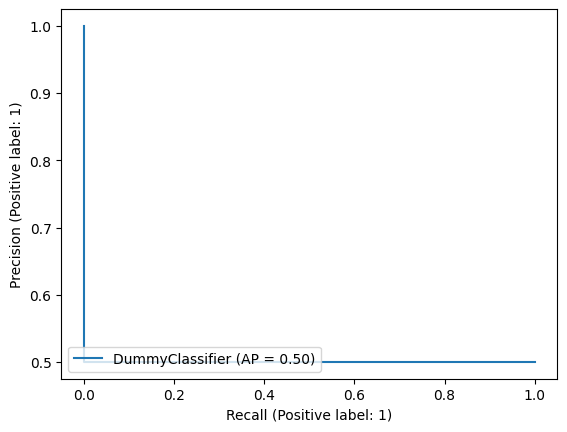

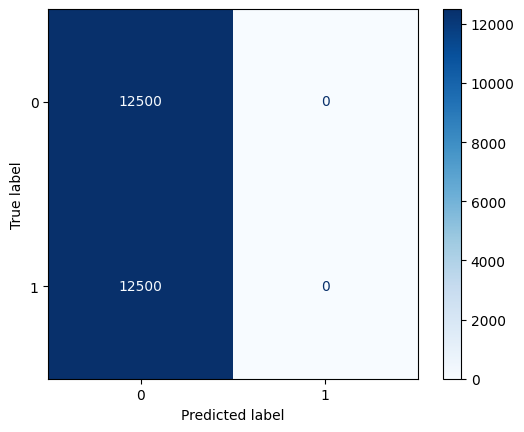

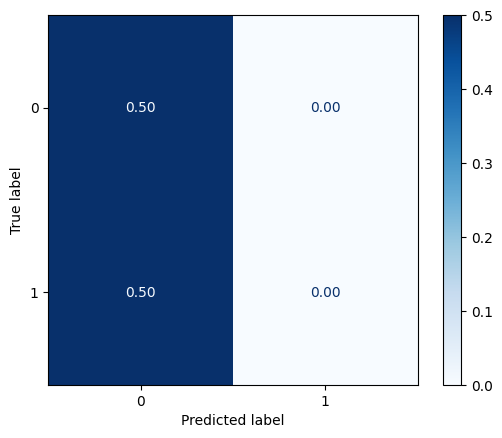

In [69]:
# plot precision/recall curve and confusion matrix
from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay, ConfusionMatrixDisplay, PrecisionRecallDisplay

PrecisionRecallDisplay.from_estimator(majority_classifier, X_test, Y_test)
ConfusionMatrixDisplay.from_estimator(majority_classifier, X_test, Y_test, normalize=None, cmap=plt.cm.Blues)
ConfusionMatrixDisplay.from_estimator(majority_classifier, X_test, Y_test, normalize='all', cmap=plt.cm.Blues, values_format=".2f")

In most cases it is better to use the normalized version, especially with unbalanced distributions!

Looking at confusion tables row-wise gives information about recall, looking column-wise gives information about precision.

<center>
    <img src="images/confusion_matrix.png" alt="confusion matrix" />
</center>

<div align='right'>
(wikipedia)
</div>

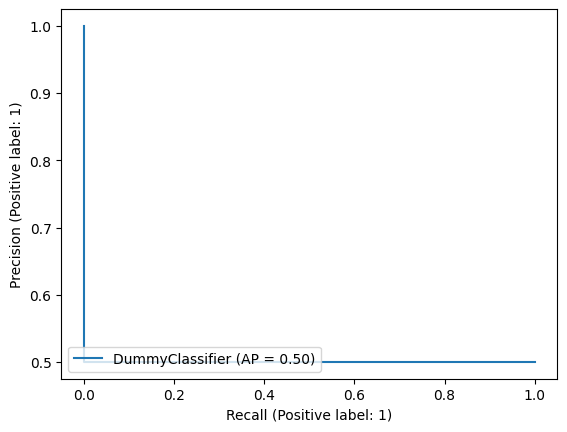

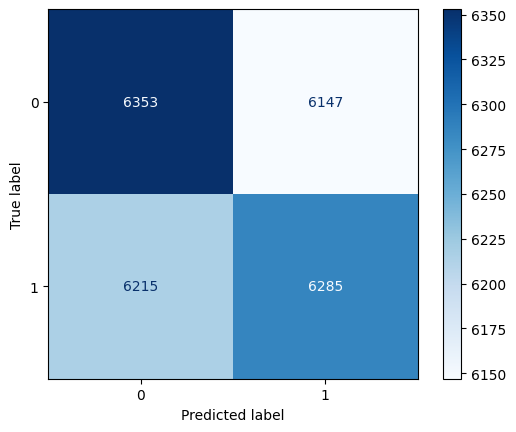

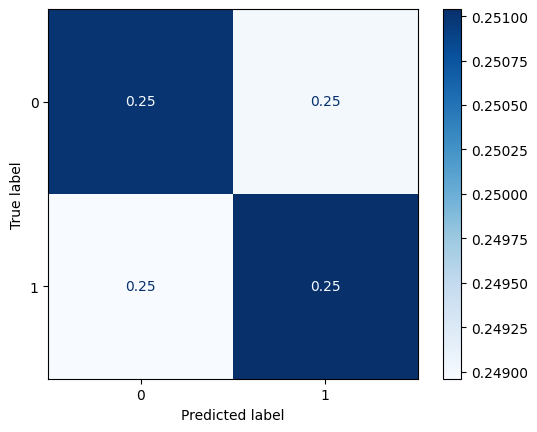

In [70]:
PrecisionRecallDisplay.from_estimator(uniform_classifier, X_test, Y_test)
ConfusionMatrixDisplay.from_estimator(uniform_classifier, X_test, Y_test, normalize=None, cmap=plt.cm.Blues)
ConfusionMatrixDisplay.from_estimator(uniform_classifier, X_test, Y_test, normalize='all', cmap=plt.cm.Blues, values_format=".2f")

### 3.2 Bayes Classifier

Let's try out our first classifier: A Naive Bayes Classifier (NB).

In [71]:
from sklearn.naive_bayes import MultinomialNB

nb_classifier = MultinomialNB()

nb_classifier.fit(X_train, Y_train)

Y_pred_train_nb = nb_classifier.predict(X_train)
Y_pred_test_nb = nb_classifier.predict(X_test)

In [72]:
evaluate_classification(y_true=Y_train, y_pred=Y_pred_train_nb)
evaluate_classification(y_true=Y_test, y_pred=Y_pred_test_nb)

              precision    recall  f1-score   support

         neg       0.89      0.93      0.91     12500
         pos       0.93      0.89      0.91     12500

    accuracy                           0.91     25000
   macro avg       0.91      0.91      0.91     25000
weighted avg       0.91      0.91      0.91     25000

              precision    recall  f1-score   support

         neg       0.79      0.89      0.84     12500
         pos       0.87      0.77      0.82     12500

    accuracy                           0.83     25000
   macro avg       0.83      0.83      0.83     25000
weighted avg       0.83      0.83      0.83     25000



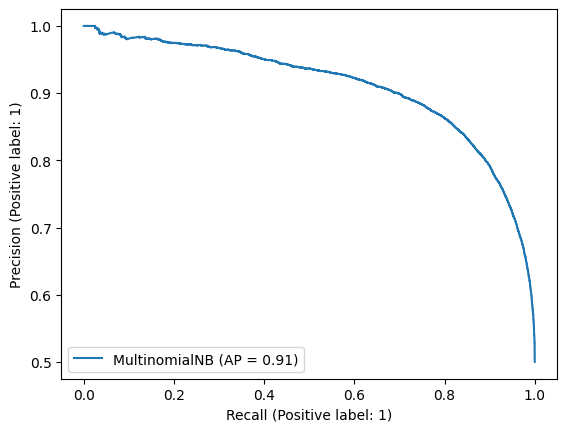

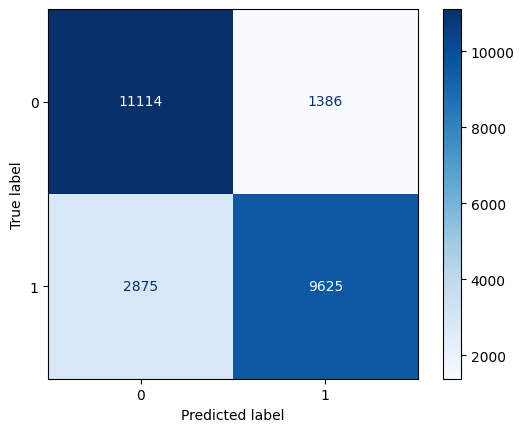

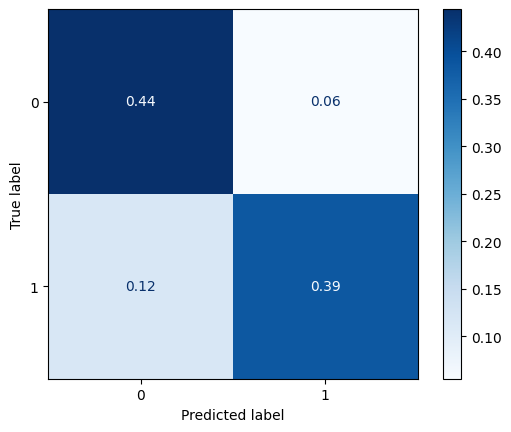

In [73]:
PrecisionRecallDisplay.from_estimator(nb_classifier, X_test, Y_test)
ConfusionMatrixDisplay.from_estimator(nb_classifier, X_test, Y_test, cmap=plt.cm.Blues)
ConfusionMatrixDisplay.from_estimator(nb_classifier, X_test, Y_test, normalize='all', cmap=plt.cm.Blues, values_format=".2f")

### 3.3 SVC Classifier

We consider another classifier: a Support Vector Machine (SVM).

In [74]:
from sklearn.svm import LinearSVC

svc_classifier = LinearSVC()

svc_classifier.fit(X_train, Y_train)

Y_pred_train_svc = svc_classifier.predict(X_train)
Y_pred_test_svc = svc_classifier.predict(X_test)

C:\Users\ardiz\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


In [75]:
evaluate_classification(y_true=Y_train, y_pred=Y_pred_train_svc)
evaluate_classification(y_true=Y_test, y_pred=Y_pred_test_svc)

              precision    recall  f1-score   support

         neg       0.99      0.99      0.99     12500
         pos       0.99      0.99      0.99     12500

    accuracy                           0.99     25000
   macro avg       0.99      0.99      0.99     25000
weighted avg       0.99      0.99      0.99     25000

              precision    recall  f1-score   support

         neg       0.87      0.89      0.88     12500
         pos       0.89      0.87      0.88     12500

    accuracy                           0.88     25000
   macro avg       0.88      0.88      0.88     25000
weighted avg       0.88      0.88      0.88     25000



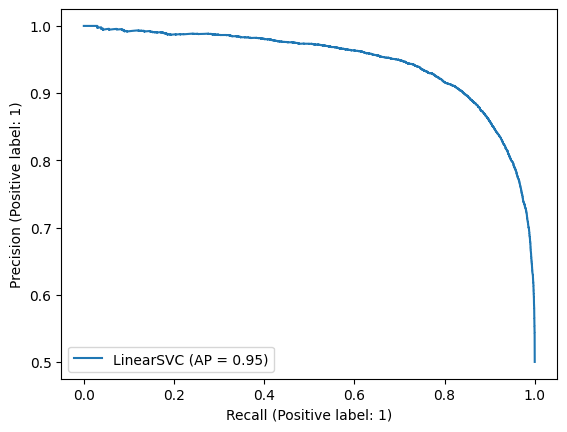

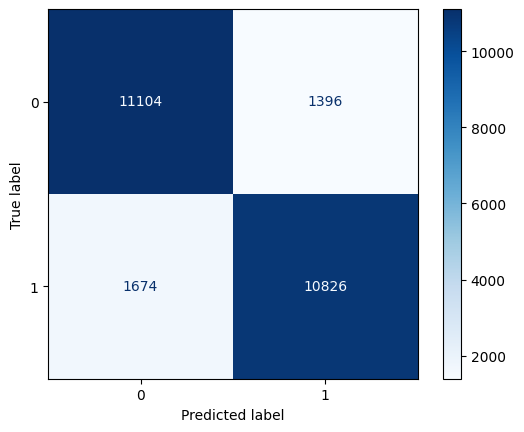

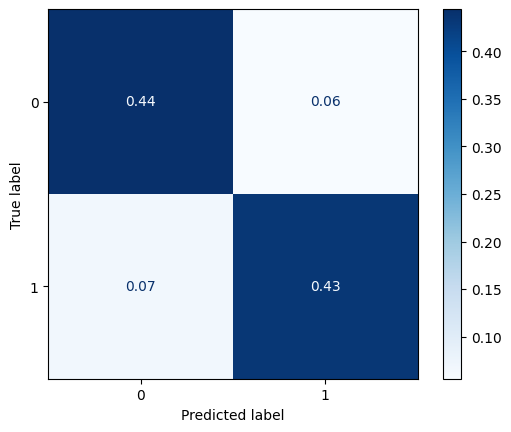

In [76]:
PrecisionRecallDisplay.from_estimator(svc_classifier, X_test, Y_test)
ConfusionMatrixDisplay.from_estimator(svc_classifier, X_test, Y_test, cmap=plt.cm.Blues)
ConfusionMatrixDisplay.from_estimator(svc_classifier, X_test, Y_test, normalize='all', cmap=plt.cm.Blues, values_format=".2f")

### 3.4 Error Analysis

Let's try to understand what kind of errors are done by the model. 

We can look at specific cases of error.

In [77]:
# confidence of the model
confidence = svc_classifier.decision_function(X_test)

fp_i = []
fn_i = []
fp_v = []
fn_v = []
fp_c = []
fn_c = []

for index, value in enumerate(Y_test):
    # false positives
    if value==0 and Y_pred_test_svc[index]==1:
        fp_i.append(index)
        fp_v.append(value)
        fp_c.append(confidence[index])
    # false negatives
    elif value==1 and Y_pred_test_svc[index]==0:
        fn_i.append(index)
        fn_v.append(value)
        fn_c.append(confidence[index])

Let's print some examples of FN and FP and the confidence in their classification

In [78]:
print("FN")

for index in [0, 3]:
    print(test_texts[fn_i[index]])
    print(fn_c[index])
    print()

FN
My wife is a mental health therapist and we watched it from beginning to end. I am the typical man and can not stand chick flicks, but this movie is unbelievable. If you want to see what it is like for someone who is going through these type of struggles, this is the movie for you. As I watched it I found myself feeling sorry for him and others like him. <br /><br />***Spoiler*** Plus the fact that all the individuals in the movie including the people in the mental institution were the actual people in real life made it that more real.<br /><br />A must see for someone in the mental health profession!
-0.3093299457020724

Naturally, along with everyone else, I was primed to expect a lot of Hollywood fantasy revisionism in THEY DIED WITH THEIR BOOTS ON over the legend of Custer. Just having someone like Errol Flynn play Custer is enough of a clue that the legend has precedence over the truth in this production. And for the most part my expectations were fulfilled (in an admittedly ro

In [79]:
print("FP")

for index in [0, 6]:
    print(test_texts[fp_i[index]])
    print(fp_c[index])
    print()

FP
Not even the Beatles could write songs everyone liked, and although Walter Hill is no mop-top he's second to none when it comes to thought provoking action movies. The nineties came and social platforms were changing in music and film, the emergence of the Rapper turned movie star was in full swing, the acting took a back seat to each man's overpowering regional accent and transparent acting. This was one of the many ice-t movies i saw as a kid and loved, only to watch them later and cringe. Bill Paxton and William Sadler are firemen with basic lives until a burning building tenant about to go up in flames hands over a map with gold implications. I hand it to Walter for quickly and neatly setting up the main characters and location. But i fault everyone involved for turning out Lame-o performances. Ice-t and cube must have been red hot at this time, and while I've enjoyed both their careers as rappers, in my opinion they fell flat in this movie. It's about ninety minutes of one guy 

We now check the sentences for which the classification error is bigger.

In [80]:
max_fp = fp_c.index(max(fp_c))
print(test_texts[fp_i[max_fp]])
print(fp_c[max_fp])

print()

# for false negatives the confidence is negative
max_fn = fn_c.index(min(fn_c))
print(test_texts[fp_i[max_fn]])
print(fn_c[max_fn])

This movie was pure genius. John Waters is brilliant. It is hilarious and I am not sick of it even after seeing it about 20 times since I bought it a few months ago. The acting is great, although Ricki Lake could have been better. And Johnny Depp is magnificent. He is such a beautiful man and a very talented actor. And seeing most of Johnny's movies, this is probably my favorite. I give it 9.5/10. Rent it today!
2.070316311391883

All I can do is echo the sentiment already expressed by some of the other commenters. This is CITY OF GOD meets HAPPY DAYS. The bipolarity of the ruthless thug (one minute a ruthless killer, the next minute a Luv's diaper commercial) is completely unconvincing. You can approach it in one of two ways: (1) A gritty, realistic movie turned sappy; or (2) a sappy, ABC-afterschool-special with profanity, violence and animal cruelty. Either way it just don't fly, do it? Why then has it received so much praise? As others have implied, it gets the "conscience vote" fr

Let's now consider the stemmed and lemmatized versions of our input features.

In [81]:
svc_classifier_st = LinearSVC()

svc_classifier_st.fit(st_X_train, Y_train)

Y_pred_train_svc_st = svc_classifier_st.predict(st_X_train)
Y_pred_test_svc_st = svc_classifier_st.predict(st_X_test)

C:\Users\ardiz\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


In [82]:
evaluate_classification(y_true=Y_train, y_pred=Y_pred_train_svc_st)
evaluate_classification(y_true=Y_test, y_pred=Y_pred_test_svc_st)

              precision    recall  f1-score   support

         neg       0.99      0.99      0.99     12500
         pos       0.99      0.99      0.99     12500

    accuracy                           0.99     25000
   macro avg       0.99      0.99      0.99     25000
weighted avg       0.99      0.99      0.99     25000

              precision    recall  f1-score   support

         neg       0.87      0.88      0.87     12500
         pos       0.88      0.86      0.87     12500

    accuracy                           0.87     25000
   macro avg       0.87      0.87      0.87     25000
weighted avg       0.87      0.87      0.87     25000



In [83]:
svc_classifier_lem = LinearSVC()

svc_classifier_lem.fit(lem_X_train, Y_train)

Y_pred_train_svc_lem = svc_classifier_lem.predict(lem_X_train)
Y_pred_test_svc_lem = svc_classifier_lem.predict(lem_X_test)

C:\Users\ardiz\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


In [84]:
evaluate_classification(y_true=Y_train, y_pred=Y_pred_train_svc_lem)
evaluate_classification(y_true=Y_test, y_pred=Y_pred_test_svc_lem)

              precision    recall  f1-score   support

         neg       0.99      0.99      0.99     12500
         pos       0.99      0.99      0.99     12500

    accuracy                           0.99     25000
   macro avg       0.99      0.99      0.99     25000
weighted avg       0.99      0.99      0.99     25000

              precision    recall  f1-score   support

         neg       0.86      0.88      0.87     12500
         pos       0.88      0.86      0.87     12500

    accuracy                           0.87     25000
   macro avg       0.87      0.87      0.87     25000
weighted avg       0.87      0.87      0.87     25000



### 3.4.1 Comparisons

Let's organize our results in a Table to better compare models.

| Model       | F1-macro |
| ---         | ---      |
| Random      | .50      |
| Majority    | .33      |
| NB          |  .83     |
| SVM         | **.88**      |
| SVM w/ Stem | .87      |
| SVM w/ Lem  | .87      |